# Group CNN in action
In this notebook we will compare the performance of a CNN model with and without group convolution.

Before running this notebook, please run model.py to train both models.

### Dataset
We will use the [FashionMNIST](https://arxiv.org/abs/1708.07747) dataset transformed with random rotations of multiples of 90 deegrees for this purpose. The dataset consists of 10 classes of clothing items. 

### Model
We will use a simple CNN model with a lifting convolutional layer, 5 convolutional layers, an average pooling layer and a linear layer. 

We will train the model **with** and **without** **group convolution** and compare the final representation and the performance of the two models.

The model **without group convolution** is trained **with data augmentation** and the model **with group convolution** is trained **without data augmentation**.



In [20]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from model import *
from group import *

cpu = torch.device("cpu")
# Number of elements in the group
GROUP_ORDER = len(CyclicGroup().elements())

Here we can see a few samples from the testing dataset

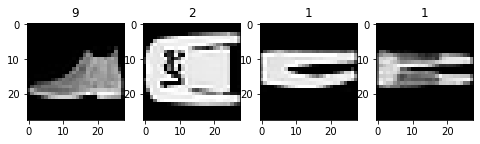

In [21]:
test_transf = transforms.Compose([transforms.ToTensor(), RandomRot90()])
test = FashionMNIST(root='./data', train=False, transform=test_transf, download=True)
# show a few samples from the testing set
n_samples = 4
fig, axs = plt.subplots(1,n_samples, figsize=(n_samples*2,2))
for i in range(n_samples):
    sample = test[i]
    axs[i].imshow(sample[0].squeeze(), cmap='gray')
    axs[i].set_title(sample[1])
plt.show()

### Test performance
Group CNN in action

In [22]:
# print accuracy on the test set
trainer = Trainer()
trainer.run_trainer()

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Total accuracy: 88.220000%


Vanilla CNN in action

In [23]:
vanilla_trainer = Trainer()
vanilla_trainer.run_trainer(use_vanilla=True)

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Total accuracy: 79.970000%


The performance of the Group CNN model is **significantly better** than the model without group convolution!

### Final representations

Let's have a look at the final representations of the two models after the pooling layer and before the final linear layer of the same image with different rotations.

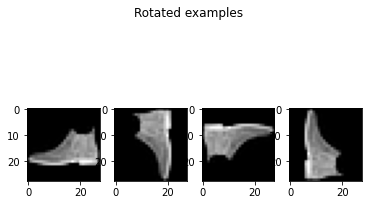

In [24]:
ex = test[0][0]
examples = torch.stack([torch.rot90(ex, i, dims=(-2,-1)) for i in range(4)])
fig, axs = plt.subplots(1,GROUP_ORDER)
for i in range(GROUP_ORDER):
    axs[i].imshow(examples[i].squeeze(), cmap='gray')

plt.suptitle("Rotated examples")
plt.show()

In [25]:
projected_examples = trainer.model.convs(examples)
projected_examples = projected_examples.reshape(projected_examples.shape[0],4,trainer.model.hidden_channel_number,
projected_examples.shape[2], projected_examples.shape[3])
projected_examples = projected_examples.mean(dim=[1, -2, -1])

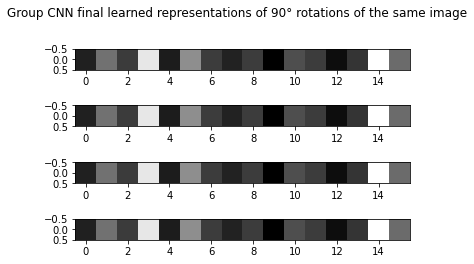

In [41]:
fig, axs = plt.subplots(GROUP_ORDER)
for i in range(GROUP_ORDER):
    axs[i].imshow(projected_examples[i, None].detach().to(cpu).numpy(), cmap='gray')
plt.suptitle("Group CNN final learned representations of 90° rotations of the same image")
plt.show()

As we can see, the Group CNN is **completely invariant** to rotations **without** requiring **any data augmentation**. This is because this Group CNN is equivariant to $Z_4$. This is a very powerful property, and it is the reason why the group CNN is able to significantly outperform the vanilla CNN.

In [30]:
vanilla_projected_examples = vanilla_trainer.model.convs(examples)
vanilla_projected_examples = vanilla_projected_examples.reshape(vanilla_projected_examples.shape[0],vanilla_trainer.model.hidden_channel_number,
vanilla_projected_examples.shape[2], vanilla_projected_examples.shape[3])
vanilla_projected_examples = vanilla_projected_examples.mean(dim=[-2, -1])

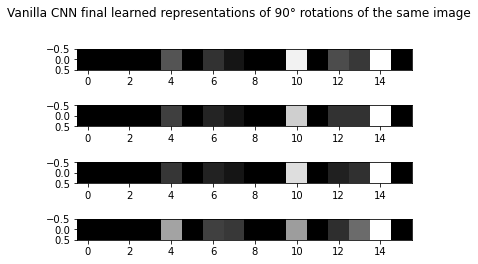

In [40]:
fig, axs = plt.subplots(GROUP_ORDER)
for i in range(GROUP_ORDER):
    axs[i].imshow(vanilla_projected_examples[i,None].detach().to(cpu).numpy(), cmap='gray')
plt.suptitle("Vanilla CNN final learned representations of 90° rotations of the same image")
plt.show()

As we can see, the vanilla CNN model, despite having been trained with data augmentation, yields features which are not invariant to rotations and, thus, it is less robust to them, providing an explanation for the gap in performance between the vanilla CNN and the Group CNN on the test set.